#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import math

In [37]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [38]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array == None:
      array = []
      for _ in range(length):
        array.append(rd.choice([0, 1]))
    self.array = array
    self.length = length

  def decode(self, lower_bound, upper_bound, aoi):
    bin_value = max_bin_val = '0b'
    for i in range(upper_bound - lower_bound + 1):
      bin_value += str(self.array[lower_bound+i])
      max_bin_val += '1'
    return min_max_norm(int(bin_value, 2), 0, int(max_bin_val, 2), aoi[0], aoi[1])

  def mutation(self, probability):
    if rd.random() < probability:
      idx = rd.randint(0, self.length-1)
      self.array[idx] = 1-self.array[idx]

  def crossover(self, other):
    cut = rd.randint(0, self.length-1)
    output_array_1 = self.array[0:cut]
    output_array_1.extend(other.array[cut:])
    output_array_2 = other.array[0:cut]
    output_array_2.extend(self.array[cut:])
    return [Chromosome(self.length, output_array_1), Chromosome(self.length, output_array_2)]

      


In [39]:
def objective_function(x1, x2):
    return 1.5 - np.exp(-x1**2 - x2**2) - 0.5 * np.exp(-(x1 - 1)**2 - (x2 + 2)**2)

In [40]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30, verbose=0):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.population = [Chromosome(chromosome_length) for _ in range(population_size)]
    self.verbose = verbose

  def eval_objective_func(self, chromosome):
    variables = []
    for i in range(self.obj_func_num_args):
      variables.append(chromosome.decode(i*self.bits_per_arg, (i+1)*self.bits_per_arg-1, self.aoi))
    return self.objective_function(*variables)

  def tournament_selection(self):
    chromosomes = rd.sample(self.population, self.tournament_size)
    return min(chromosomes, key=lambda chromosome: self.eval_objective_func(chromosome))
  

  def reproduce(self, parents):
    if rd.random() < self.crossover_probability:
      return parents[0].crossover(parents[1])
    else:
      return parents

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    best_chromosomes = []
    best_chromosomes.append(min(self.population, key=lambda chromosome: self.eval_objective_func(chromosome)))

    for _ in range(self.num_steps):
      temp_population = []
      population_size = len(self.population)

      for _ in range(round(population_size/2)):
        parents = rd.sample(self.population, 2)
        temp = self.reproduce(parents)
        temp_population.append(temp[0])
        temp_population.append(temp[1])

      for i in range(population_size):
        temp_population[i].mutation(self.mutation_probability)
      self.population, temp_population = temp_population, []

      for _ in range(population_size):
        temp_population.append(self.tournament_selection())
      self.population = temp_population

      best_chromosomes.append(min(self.population, key=lambda chromosome: self.eval_objective_func(chromosome)))

    
    trace = []
    for chromosome in best_chromosomes:
      if self.verbose:
        msg = f'Value: {round(self.eval_objective_func(chromosome), 5)} '
      point = []
      for i in range(self.obj_func_num_args):
        point.append(chromosome.decode(i*self.bits_per_arg, (i+1)*self.bits_per_arg-1, self.aoi))
        if self.verbose:
          msg += f'x{i}={round(point[i], 5)} '
      if self.verbose:
        print(msg)
      trace.append(point)
    self.plot_func(trace)
      
    

aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


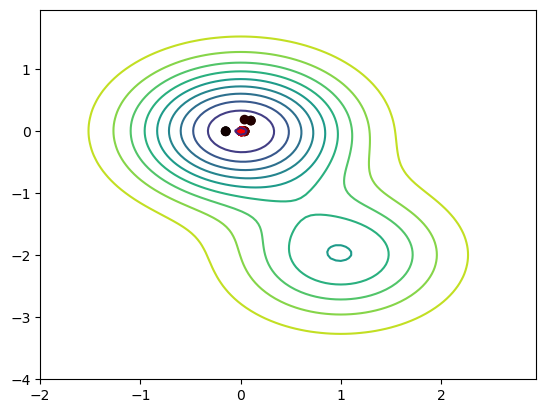

aoi:[-8, 8] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


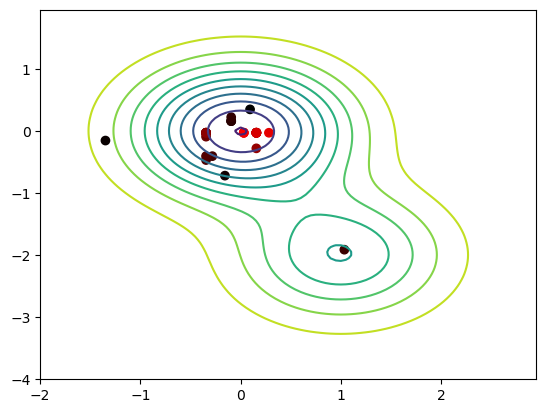

aoi:[-30, 30] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


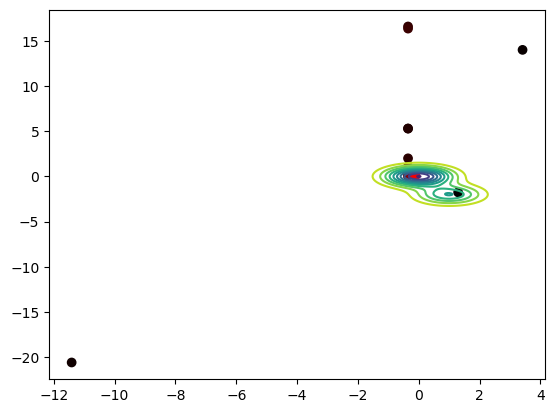

aoi:[-2, 2] population size:10 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


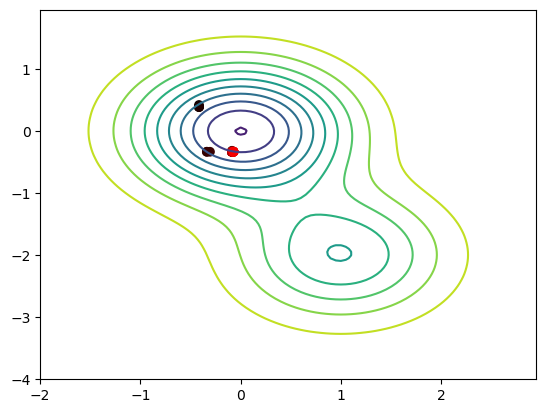

aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


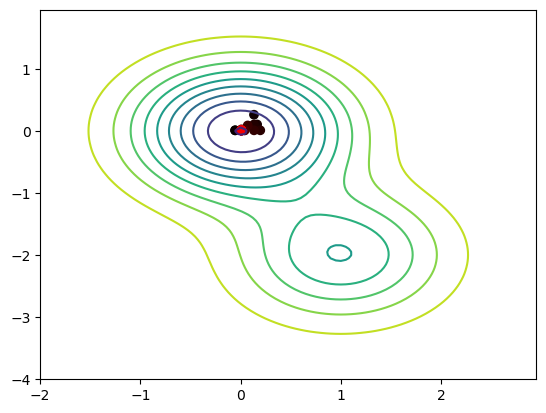

aoi:[-2, 2] population size:1000 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


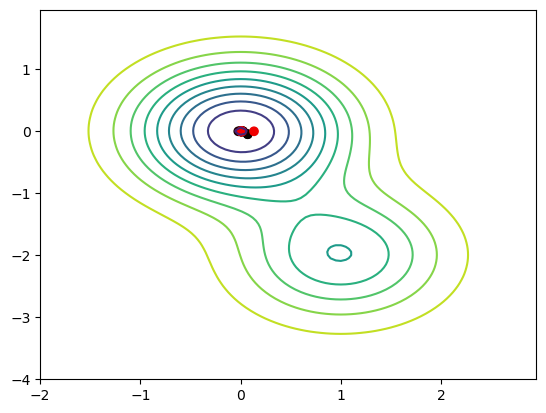

aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


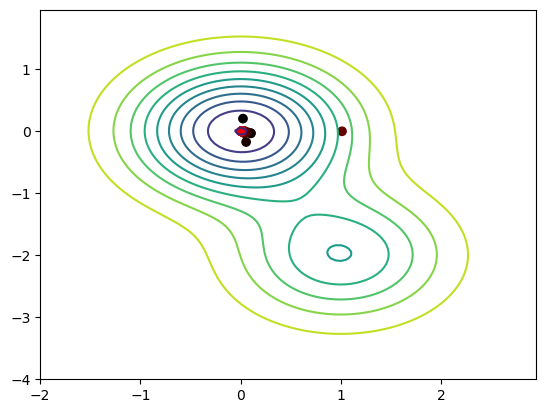

aoi:[-2, 2] population size:100 crossover_propability:0.4 mutation_propability:0.05 tournament_size:2


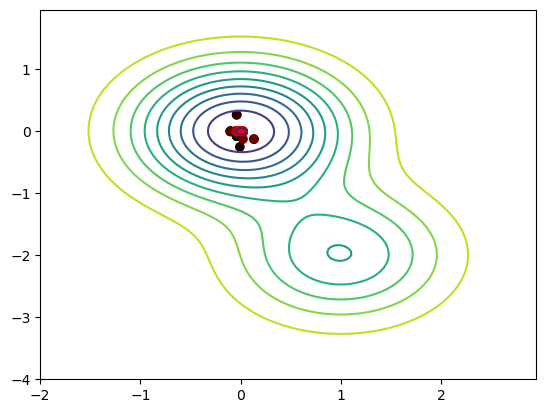

aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


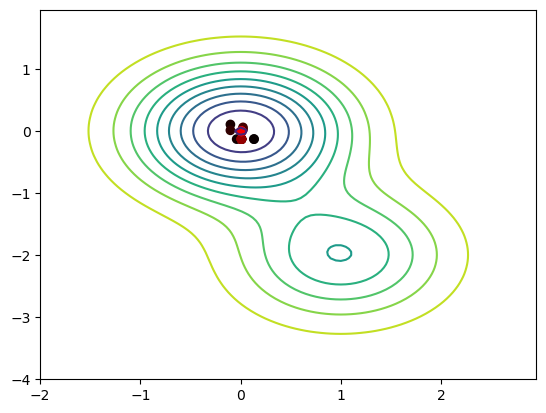

aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:0.3 tournament_size:2


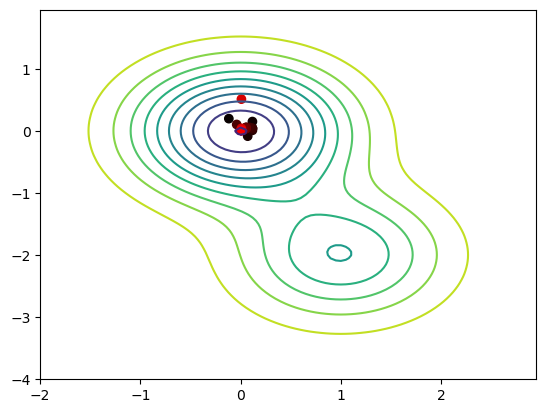

aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2


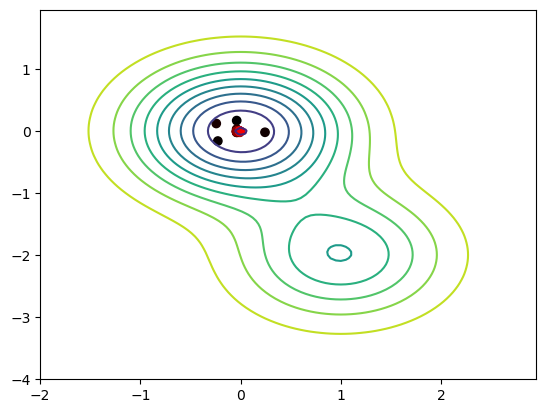

aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:4


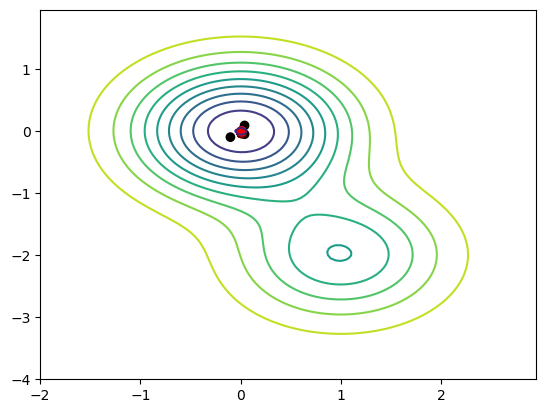

In [41]:
# aoi = [-3.5, 3.5]
# GenAlgoritm = GeneticAlgorithm(16, 2, objective_function, aoi, population_size=100, num_steps=200)
# GenAlgoritm.run()

aois = [[-2, 2], [-8, 8], [-30, 30]]
populations = [10, 100, 1000]
crossover_propability = [0.8, 0.4]
mutation_propability = [0.05, 0.3]
tournament_size = [2, 4]
for aoi in aois:
    print(f'aoi:{aoi} population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:2')
    ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function, aoi=aoi, population_size=100)
    ga.run()

for population in populations:
    print(f'aoi:[-2, 2] population size:{population} crossover_propability:0.8 mutation_propability:0.05 tournament_size:2')
    ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function, aoi=aois[0], population_size=population)
    ga.run()

for cross_pro in crossover_propability:
    print(f'aoi:[-2, 2] population size:100 crossover_propability:{cross_pro} mutation_propability:0.05 tournament_size:2')
    ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function, aoi=aois[0], population_size=100, crossover_probability=cross_pro)
    ga.run()
       
for mut_pro in mutation_propability:
    print(f'aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:{mut_pro} tournament_size:2')
    ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function, aoi=aois[0], population_size=100, mutation_probability=mut_pro)
    ga.run() 

for tour in tournament_size:
    print(f'aoi:[-2, 2] population size:100 crossover_propability:0.8 mutation_propability:0.05 tournament_size:{tour}')
    ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function, aoi=aois[0], population_size=100, tournament_size=tour)
    ga.run()

# .replace('.', '')

